In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will
seek to predict Sales using regression trees and related approaches,
treating the response as a quantitative variable.



(a) Split the data set into a training set and a test set. 18 


(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain? 5,11,12..


(c) Use cross-validation in order to determine the optimal level of
tree complexity. Does pruning the tree improve the test MSE?


(d) Use the bagging approach in order to analyze this data. What
test MSE do you obtain? Use the importance() function to determine which variables are most important.
334 8. Tree-Based Methods


(e) Use random forests to analyze this data. What test MSE do you
obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of
variables considered at each split, on the error rate
obtained

In [1]:
pwd

'/content'

In [2]:
cd /content/drive/MyDrive/Colab Notebooks/Machine Learning/HW#5

/content/drive/MyDrive/Colab Notebooks/Machine Learning/HW#5


In [3]:
#import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

%matplotlib inline
plt.style.use('seaborn-white')


In [4]:
carsets=pd.read_csv("Carseats.csv", index_col=0)
carsets.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
1,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
2,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
3,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
4,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
5,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(a) Split the data set into a training set and a test set.

In [5]:

carsets['US'] = carsets['US'].map({'Yes': 1, 'No': 0})
carsets['Urban'] = carsets['Urban'].map({'Yes': 1, 'No': 0})
carsets = pd.get_dummies(carsets, prefix=['ShelveLoc'])
carsets = carsets.rename(columns={'Unnamed: 0': 'Id'})

X_train, X_test, y_train, y_test = train_test_split(carsets.drop(['Sales'], axis=1),
                                                    carsets[['Sales']], test_size=0.1)

In [6]:
X_train.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium
325,136,65,4,133,150,53,13,1,1,1,0,0
197,130,28,6,410,133,72,16,1,1,1,0,0
380,125,111,0,404,107,54,15,1,0,1,0,0
134,132,98,2,265,97,62,12,1,1,1,0,0
237,141,34,16,361,108,69,10,1,1,0,0,1


(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test error rate do you obtain?

In [7]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

regressor = DecisionTreeRegressor(random_state=0, min_samples_split=20)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [8]:
DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=20,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=0, splitter='best')

In [9]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        print("Could not run dot, ie graphviz, to "
             "produce visualization")

visualize_tree(regressor, X_train.columns.tolist())

p = regressor.predict(X_test)
print("Test MSE is: " + str(mean_squared_error(p, y_test)))

Could not run dot, ie graphviz, to produce visualization
Test MSE is: 6.104509435667805


c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test error rate?

In [10]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

parameters = {'max_depth':range(1,30)}
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
clf = GridSearchCV(tree.DecisionTreeRegressor(random_state=1), parameters, n_jobs=4, cv=10,
                   scoring=mse_scorer)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)

-4.182913861642733 {'max_depth': 9}


In [16]:
p = tree_model.predict(X_test)
print("Test MSE is: " + str(mean_squared_error(p, y_test)))

Test MSE is: 5.546315396208982


(d) Use the bagging approach in order to analyze this data. What test error rate do you obtain? Use the importance() function to determine which variables are most important.

In [17]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor(random_state=0)
bagging.fit(X=X_train, y=y_train.values.ravel())

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10,
                 n_jobs=None, oob_score=False, random_state=0, verbose=0,
                 warm_start=False)

In [18]:
BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=1,
                 oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
p = bagging.predict(X_test)
print("Test MSE is: " + str(mean_squared_error(p, y_test)))

Test MSE is: 4.2414220999999985


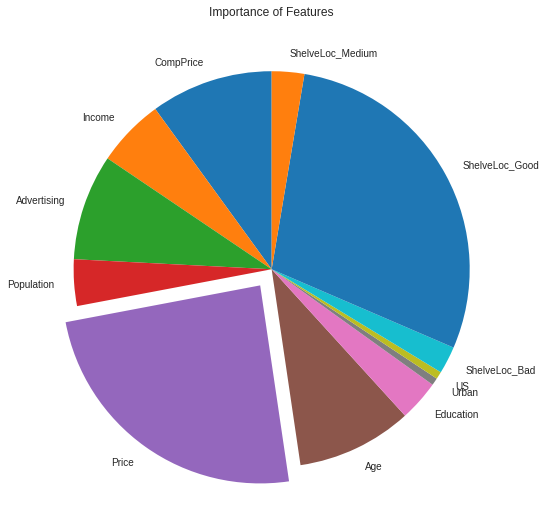

In [21]:
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)
explode = (0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)

plt.pie(feature_importances, explode=explode, labels=X_train.columns.tolist(), startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')
plt.tight_layout()
plt.title("Importance of Features")
plt.show()

(e) Use random forests to analyze this data. What test error rate do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [22]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(random_state=0)
random_forest.fit(X=X_train, y=y_train.values.ravel())
p = random_forest.predict(X_test)
print("Test MSE is: " + str(mean_squared_error(p, y_test)))

Test MSE is: 3.9124140047500022


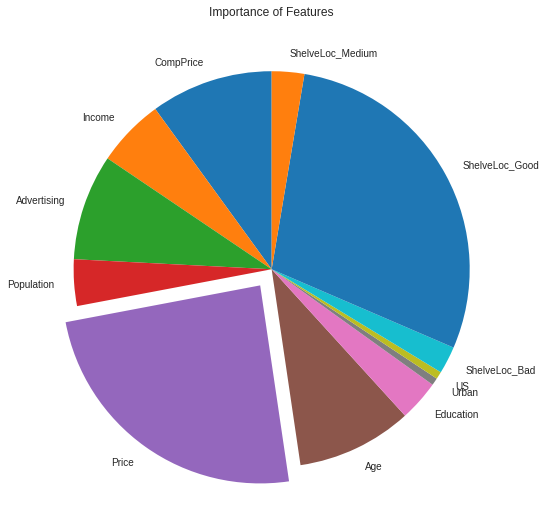

In [24]:
explode = (0, 0, 0, 0, 0.1, 0, 0, 0, 0, 0, 0, 0)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121)

plt.pie(feature_importances, explode=explode, labels=X_train.columns.tolist(), startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')
plt.tight_layout()
plt.title("Importance of Features")
plt.show()